In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: unexpected EOF while parsing (4179869896.py, line 17)

In [2]:
import os  #reading images
import pickle #storing some numpy features like read images features or else we would have to do it again
import numpy as np
from tqdm.notebook import tqdm  #represents how much data has been processed during a task ...for estimation

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#to preprocess text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  #sentences would be of different lengths ..so to fill out the remaining with zeros to equalize all the lengths
from tensorflow.keras.models import Model

#utility
from tensorflow.keras.utils import to_categorical, plot_model  #represent model in form of image, plots
from tensorflow.keras.layers import Input, Dense,LSTM, Embedding, Dropout, add

In [3]:
base_dir='/kaggle/input/flickr8k'
working_dir = '/kaggle/working'

In [4]:
#extract image features
#load model(vgg16)
model=VGG16()
model=Model(inputs=model.inputs, outputs= model.layers[-2].output) #leaving last layers
#summary
print(model.summary())

2023-01-05 11:34:53.900822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:34:53.901780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:34:54.152785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:34:54.153702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:34:54.154486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
#extract features from image
#dictionary : features=value, key= image id

features={}
directory= os.path.join(base_dir, 'Images')  #path to find the images

for img_name in tqdm(os.listdir(directory)):
    #loading img from file
    img_path= directory + '/' + img_name
    image=load_img(img_path, target_size= (224, 224))
    #convert image pixels to numpy array
    image= img_to_array(image)
    #reshape for model
    image= image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #((1 sample, rgb))
    #preprocess for vgg
    image= preprocess_input(image)
    #extract features
    feature = model.predict(image,verbose = 0) #verbose 0 means it wont write anything on image
    #here we have removed the prediction layers in the vgg so it captures last flatten layer details
    #get image id
    image_id = img_name.split('.')[0]  #taking 1st part of the split
    #store features
    features[image_id]=feature   #features=value, key= image id



  0%|          | 0/8091 [00:00<?, ?it/s]

2023-01-05 07:42:37.189783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-05 07:42:39.173655: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


KeyboardInterrupt: 

In [11]:
#store features in pickle
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb')) #open(path...this will be associated with the working dir..we are saving in working dir), save as binary

In [14]:
#opening the saved file
with open(os.path.join(working_dir, 'features.pkl'),'rb') as f:  #rb= read binary
    features=pickle.load(f)

In [5]:
with open(os.path.join('/kaggle/input/featurespkl/features.pkl'),'rb') as f:  #rb= read binary
    features=pickle.load(f)

In [6]:
features['3226254560_2f8ac147ea']

array([[0.       , 1.627393 , 0.       , ..., 0.       , 1.5637901,
        0.       ]], dtype=float32)

In [7]:
len(features)

8091

In [8]:
#load the captions data
with open(os.path.join(base_dir, 'captions.txt'),'r') as f:  #r= read
    next(f)       #skipping to next line as the 1st line in the file is just image,captions
    captions_doc= f.read()

In [9]:
#now doing similar thing as feature extraction : each image_id : caption 
#mapping
mapping={}
#process lines
for line in tqdm(captions_doc.split('\n')):  #going line by line
    tokens= line.split(',')
    if len(line)<2:
        continue        #greater might be an error
    image_id,caption = tokens[0], tokens[1:]  #[0] is id, [1:] from index1 to end caption
    #removing extension .jpg from id
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption= ' '.join(caption)
    #if for a given id there is only one caption append to a new list
    if image_id not in mapping:
        mapping[image_id]=[]
    #if multiple captions present
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

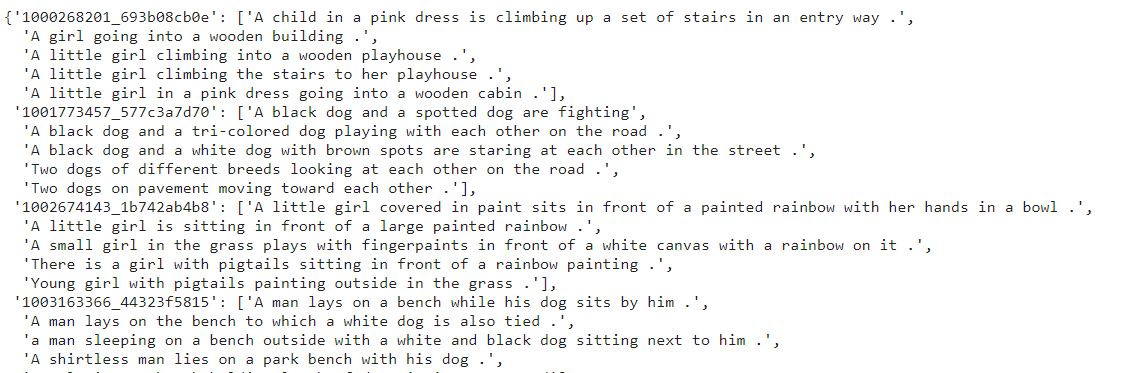](http://)

In [12]:
#preprocess the caption
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]  #take one at a time
            #preprocess
            caption = caption.lower()  #converting in lower case
            caption= caption.replace('[^A-Za-z]','')   #remove everything except ALPHABETS
            caption = caption.replace('/s+',' ')  #replace multiple spaces with one space
            #remove single cha words like 'a'
            caption = ' '.join([word for word in caption.split() if len(word)>1])
            #usually done for seq2seq model
            #add start and end tags to captions
            caption = 'start ' + caption + ' end'    ####
            captions[i]=caption

In [13]:
mapping['1000268201_693b08cb0e']  #before preprocessing

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
clean(mapping)

In [15]:
mapping['1000268201_693b08cb0e']  #after preprocess

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [16]:
#using tokenizer to get the index of the words
all_captions =[]
for key in mapping:
    for caption in mapping[key]:    #can use mapping.key
        all_captions.append(caption)   #taking all captions to further process

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [19]:
#tokensir
tokenizer= Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) +1   #no. of unique words

In [20]:
vocab_size

8483

In [21]:
#finding the len of longest caption for padding as discussed earlier
max_length = max(len(caption.split()) for caption in all_captions)

In [22]:
max_length

35

In [23]:
#train test split
image_ids = list(mapping.keys())
split= int(len(image_ids) * 0.9)
train = image_ids[:split]
test= image_ids[split:]

In [24]:
len(train)

7281

In [ ]:
#'<start>girl going into wooden building<end>'
#step1: x= <start>     y= girl   y=prediction
#concatinate x and y with space and use it as x for nxt
#step2 : x=<start>girl   y= going
#concatenate and continue and predict
#final step:   x= <start>....whole sentence   y=<end>

In [25]:
#if low on memory use this data generator to get data in batch to avoid session crash
def data_generator(data_keys, mapping, features, tokenizer,max_length,vocab_size,batch_size):
    X1,X2,y = [], [], []
    n=0  #just to see which are going on
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            #process each caption
            for caption in captions:
                #encode seq
                seq = tokenizer.texts_to_sequences([caption]) #seq= seq index
                #print(seq)
                seq=seq[0]
                #split seq into x, y pairs..input,output  refer to prev comments code box
                for i in range(1,len(seq)):
                    #split into input and pout[ut]
                    in_seq, out_seq = seq[:i], seq[i]   #in = <start> i.e till i word, out = ith word
                    #print(in_seq,out_seq)
                    #pading to have common length of all seq
                    in_seq = pad_sequences([in_seq], maxlen = max_length)  #gives the list of padded seq...here we r passing only one seq..so [0]
                    #print(in_seq)
                    in_seq = in_seq[0]
                    #encode output seq
                    out_seq = to_categorical([out_seq],num_classes= vocab_size)[0]
                    #print(out_seq)
                    
                    #store the seq
                    X1.append(features[key][0])  #image features as input
                    X2.append(in_seq)            #text features as input
                    y.append(out_seq)            #nxt word as output...predict by using both image features and text features
                
                #process in batch
                if n==batch_size:
                    X1,X2,y= np.array(X1), np.array(X2),np.array(y)
                    yield [X1, X2],y   #return collected data to generator 
                    X1,X2,y = [],[],[]   #to erase collected data to avoid exhausting memory
                    n=0

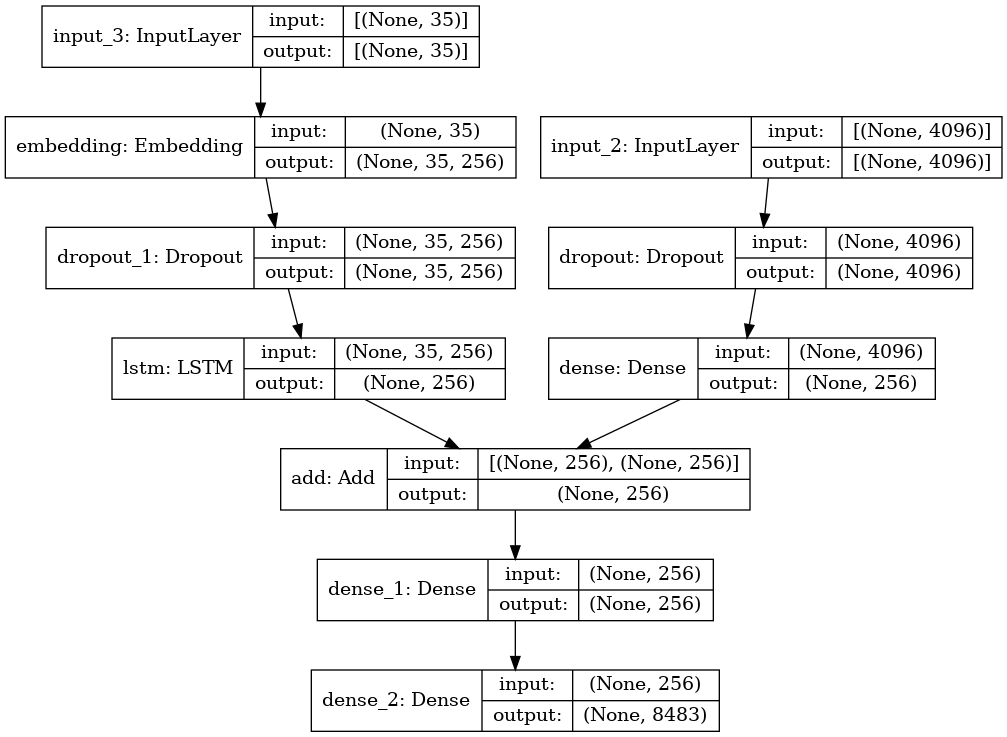

In [26]:
#model creation
#concatenate the 2 features and plot the model
#encoder model: image and text feature model
inputs1 = Input(shape=(4096,))    #output of vgg i.e feature shape 
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
#seq feature layer
inputs2= Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)  #mask_zero= as we r padding
se2= Dropout(0.4)(se1)
se3= LSTM(256)(se2)

#decoder model : concatenate both features
decoder1= add([fe2, se3])
decoder2 = Dense(256, activation= 'relu')(decoder1)

outputs = Dense(vocab_size,activation='softmax')(decoder2)   #softmax for categorical

model = Model(inputs= [inputs1, inputs2], outputs= outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot the model
plot_model(model, show_shapes=True)

In [27]:
import numpy as np
#training
epochs = 25
batch_size= 64
steps= len(train)//batch_size  #after each step it will do the backprop and fetch nxt data ..see the diff between epoch and step...epoch might be all the steps 

for i in range(epochs):
    #create generator data 
    generator= data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    #fit for an epoch
    model.fit(generator, epochs=1,steps_per_epoch=steps, verbose=1)
    

2023-01-05 11:36:05.468427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


113/113 [==============================] - 61s 537ms/step - loss: 2.1451


In [28]:
model.save('best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [29]:
#generate captions for image
#convert id to word
def index_to_word(integer,tokenizer):  #all the things we will get from model will be integers..so with the help of tokenizer convert to word for caption
    for word, index in tokenizer.word_index.items():
        if index==integer:   #iterating thr the available words in tokenizer, if the given integer is in that ..index matches ..output the word
            return word
    return None               #if not found return none

In [30]:
#generate caption for a new image
#do all the things sequentially ..as in the whole code
def predict_caption(model,image,tokenizer,max_length):
    #add strat tag for generation
    in_text= 'start'
    #iterate over the max length of seq
    for i in range(max_length):
        #convert seq into integer
        sequence = tokenizer.texts_to_sequences([in_text])[0]   #already done in prev lines 
        #pad the seq
        sequence = pad_sequences([sequence], max_length)
        #predict nxt word
        yhat= model.predict([image, sequence], verbose=0)
        #yhat gives prob of all the index ..so aroun 8k ...vocab_length ..unique words
        #to get index with higgest prob:
        yhat=np.argmax(yhat)
        #convert index to word:
        word = index_to_word(yhat,tokenizer)
        #stop if word not found
        if word is None:
            break
        #append word as input for generating nxt word
        in_text += ' ' + word  #this will be used as nxt input 
        #stop is tag is end
        if word=='end':
            break
    return in_text
        

In [31]:
#validation with test data
actual,predicted=[],[]

for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    #predict the caption
    y_pred=predict_caption(model,features[key], tokenizer, max_length)  #text obtained
    y_pred = y_pred.split()  #generates list of all the words in captions
    actual_caption=[caption.split() for caption in captions]  #generates list of all the words in captions
    actual.append(actual_caption)
    predicted.append(y_pred)
    
#cal BLUE score ..cal whenever dealing with text data
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1:%f' %corpus_bleu(actual, predicted, weights= (1.0, 0, 0, 0)))  #for one word
print('BLEU-2:%f' %corpus_bleu(actual, predicted, weights= (0.5, 0.5, 0, 0)))  #for 2 word

  0%|          | 0/810 [00:00<?, ?it/s]

2023-01-05 12:15:36.447376: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


BLEU-1:0.535013
BLEU-2:0.315080


bleu (0-1) ..higher score is better

In [32]:
#visualize the results

from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    #image_name=''
    image_id = image_name.split('.')[0]
    image_path = os.path.join(base_dir, 'Images', image_name)
    image= Image.open(image_path)
    captions=mapping[image_id]
    print('actual')
    for caption in captions:
        print(caption)  #actual caption

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)  #prediction
    #display predicted
    print('predicted')
    print(y_pred)
    plt.imshow(image)

actual
start brown dog chases the water from sprinkler on lawn end
start brown dog plays with the hose end
start brown dog running on lawn near garden hose end
start dog is playing with hose end
start large brown dog running away from the sprinkler in the grass end
predicted
start dog is running through lawn end


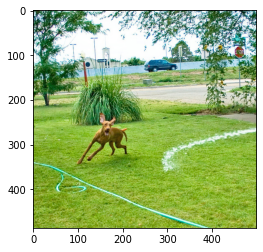

In [33]:
image_name='1019077836_6fc9b15408.jpg'
generate_caption(image_name)

actual
start brown dog is running after black dog on rocky shore end
start brown dog is running after the black dog end
start two dogs playing on beach end
start two dogs run across stones near body of water end
start two dogs run towards each other on rocky area with water in the background end
predicted
start two dogs are playing on the beach end


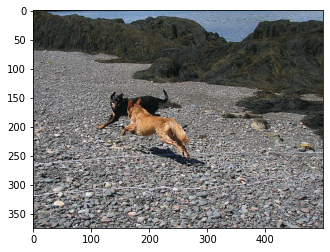

In [35]:
image_name='1056873310_49c665eb22.jpg'
generate_caption(image_name)